In [2]:
import numpy as np
import matplotlib.pyplot as plt
from z3 import *
import torch
import time
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from Z3_Tools import *
from utils import *
from models import * 

## (1) Z3 Logic 

In [3]:
s = Solver()
s.add(parse("A|B"))
s.add(parse("A->C"))
s.add(parse("B->C"))
s.add(Not(parse("C")))

print(s.check())

unsat


In [4]:
## Test Verifier 
known = ["A|B", "A->C"]
proposal = "C"

is_valid = verify_step(known, proposal)
print("Is the step valid?", is_valid)

Is the step valid? False


## (2) Enumerate Propositional Logic Statements

In [5]:
ALL_FORMULAS = ["A", "B", "C", "D",
                "~A", "~B", "~C",  "~D", 
                "A->B", "A->C", "B->C", "A->D", "B->D", "C->D",
                "B->A", "C->A", "C->B", "D->A", "D->B", "D->C",
                "A&B", "B&C", "A&C", "A&D", "B&D", "C&D", 
                "A|B", "B|C", "A|C", "A|D", "B|D", "C|D", ]

# Define ALL_STATES from many random subsets of ALL_FORMULAS
# Ignore false states (check this by ensuring a -> false is false, which means a is true) 
N = 6000; ALL_STATES = set(); 
while len(ALL_STATES) < N: 
    subset = frozenset(random_subset(ALL_FORMULAS, 1, 4))
    if not verify_step(list(subset), "A & ~A"): 
        ALL_STATES.add(subset)
print(len(ALL_STATES))

6000


In [6]:
total = len(ALL_STATES) * len(ALL_FORMULAS)
X_states, X_props, Y_labels = [], [], []
count = 0

for known in ALL_STATES:
    known = list(known)
    for prop in ALL_FORMULAS:
        label = verify_step(known, prop)
        
        X_states.append(known)
        X_props.append(prop)
        Y_labels.append(int(label))
        count += 1
        if count % 50000 == 0:
            print(f"{count} / {total} samples done")

50000 / 192000 samples done
100000 / 192000 samples done
150000 / 192000 samples done


In [7]:
print(X_states[5])
print(X_props[5])
print(Y_labels[5])

['A|C', 'A&C', 'C']
~B
0


In [8]:
## Can also save to .npz and load later ... 
# data = np.load("logic_dataset.npz")
# X_states = data["X_states"]
# X_props  = data["X_props"]
# Y        = data["Y"]

## (3) Train on Prop Logic 

In [9]:
# Define one-hot-encoding map and state encoder 
OneHot_Map = {f:i for i,f in enumerate(ALL_FORMULAS)}

# Map X_props, X_states to One-Hot 
X_props_Map = np.array([OneHot_Map[p] for p in X_props])
X_props_1h = np.eye(len(ALL_FORMULAS))[X_props_Map]  # basically defining a repeating list of I rows ... 
X_states_1h = np.array([encode_state(s, ALL_FORMULAS) for s in X_states])

print(X_props[8])
print(X_props_Map[15])
print(X_props_1h[15])
print(X_states[15])
print(X_states_1h[5])

A->B
15
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
['A|C', 'A&C', 'C']
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0.]


0 0.6938360333442688
50 0.5233249068260193
100 0.3294892907142639
150 0.14027249813079834
200 0.06397678703069687
250 0.03491726517677307


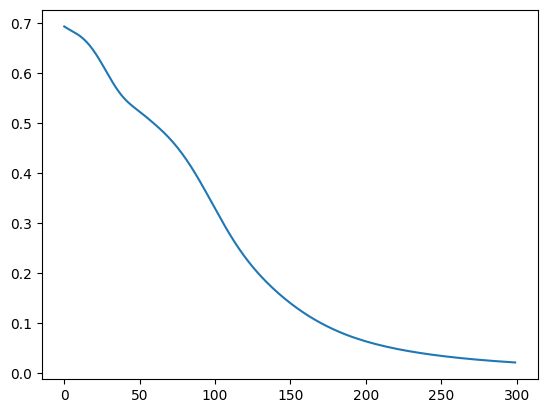

In [10]:
## Define X, Y, train/test split 
X = np.concatenate([X_props_1h, X_states_1h], axis=1)
Y = np.array(Y_labels).astype(float)
Xtr, Xte, ytr, yte = train_test_split(X, Y, test_size=0.2, random_state=0)

## Define model 
model = nn.Sequential(
    nn.Linear(X.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

## Train
Xt = torch.tensor(Xtr, dtype=torch.float32)
yt = torch.tensor(ytr, dtype=torch.float32).unsqueeze(1)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

losses = []
for epoch in range(300):
    opt.zero_grad()
    ypred = model(Xt)
    loss = loss_fn(ypred, yt)
    loss.backward()
    opt.step()
    if epoch%50==0: print(epoch, loss.item())
    losses.append(loss.item())

plt.plot(losses);

In [11]:
# Eval 
with torch.no_grad():
    Xtest = torch.tensor(Xte, dtype=torch.float32)
    ytest = torch.tensor(yte, dtype=torch.float32).unsqueeze(1)
    preds = (model(Xtest) > 0.5).float()
    acc = (preds == ytest).float().mean()

print("Test accuracy:", acc.item())

Test accuracy: 0.9939062595367432


# (4) Baby Theorem Prover

In [12]:
testinput = np.concatenate([encode_state(['A', 'C'], ALL_FORMULAS), encode_state(['B'], ALL_FORMULAS)])
torch_input = torch.tensor([testinput], dtype=torch.float32)
test_output = model(torch_input)
print(test_output.item())

1.2308347550060716e-06


/var/folders/3b/1lt3qrpn635524qxcctqlg040000gn/T/ipykernel_33745/496936223.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  torch_input = torch.tensor([testinput], dtype=torch.float32)


In [13]:
## Idea: 
## (1) NN is given a state, gives probability of truth for a given formula.
## (2) Each formula is ranked based on the model. 
## (3) Highest rank is 'chosen' (if it agrees with Z3)

example_state = ['A', 'C']
print(nn_score(example_state, 'B', model, ALL_FORMULAS))
print(rank_candidates(example_state, model, ALL_FORMULAS))
print(pick_valid_step(example_state, model, ALL_FORMULAS, 5))

1.2308347550060716e-06
[('A&C', 0.9999861717224121), ('C', 0.8413538336753845), ('C&D', 0.3619649112224579), ('B&C', 0.23553374409675598), ('A', 0.13219085335731506), ('A&D', 0.09103123098611832), ('A&B', 0.05668594315648079), ('A|C', 0.003817562712356448), ('D->C', 0.00017818716878537089), ('B->C', 5.7427339925197884e-05), ('~D', 5.15579704369884e-05), ('~B', 2.4825087166391313e-05), ('C|D', 2.0007781131425872e-05), ('D->A', 1.7297101294388995e-05), ('B->A', 1.6157289792317897e-05), ('A->C', 1.5745608834549785e-05), ('B|C', 1.5712279491708614e-05), ('A|B', 5.629816314467462e-06), ('A|D', 2.8529375413199887e-06), ('B&D', 1.7937792335942504e-06), ('C->A', 1.513194433755416e-06), ('A->D', 1.3390139201874263e-06), ('B', 1.2308347550060716e-06), ('D', 6.629685458392487e-07), ('C->D', 5.542459007301659e-07), ('C->B', 4.260783725840156e-07), ('B|D', 3.6927258406649344e-07), ('A->B', 3.06524555071519e-07), ('~A', 2.859737264770956e-07), ('~C', 2.53576473596695e-07), ('B->D', 2.413559343494853

In [14]:
rank_candidates(['A', 'A->B', 'B->C'], model, ALL_FORMULAS)

[('B&C', 0.999995231628418),
 ('A&C', 0.9999711513519287),
 ('C', 0.9985398054122925),
 ('A&B', 0.9969897270202637),
 ('C&D', 0.9866665005683899),
 ('B->C', 0.9681537747383118),
 ('~B', 0.8335569500923157),
 ('~A', 0.8333803415298462),
 ('B', 0.7820128202438354),
 ('A->B', 0.7657790780067444),
 ('B&D', 0.667675793170929),
 ('A', 0.6584126949310303),
 ('A|C', 0.5631508827209473),
 ('~D', 0.5278584361076355),
 ('A->C', 0.5180784463882446),
 ('D->C', 0.37600308656692505),
 ('A&D', 0.3587425649166107),
 ('B->A', 0.10897138714790344),
 ('B|D', 0.08864589780569077),
 ('C->B', 0.08151300996541977),
 ('C|D', 0.07424883544445038),
 ('A|B', 0.06526479125022888),
 ('D->A', 0.03995276615023613),
 ('B|C', 0.03268731012940407),
 ('D->B', 0.022713279351592064),
 ('A|D', 0.016918370500206947),
 ('B->D', 0.016623729839920998),
 ('A->D', 0.009538032114505768),
 ('C->A', 0.006618781015276909),
 ('D', 0.002594134770333767),
 ('~C', 0.0016924177762120962),
 ('C->D', 0.0008445349521934986)]

In [15]:
def TheoremProver(state, objective, model, ALL_FORMULAS): 
    while objective not in state: 
        winner = pick_valid_step(state, model, ALL_FORMULAS, 10)[0]
        if winner is None: 
            print("No valid step found. Proof failed.")
            return None
        print(f'NN guess : {winner}')
        state.append(winner)
        print(f'New state: {state}')
    print('Proved!')

In [16]:
TheoremProver(['A', 'A->B', 'B->C'], 'C', model, ALL_FORMULAS)
TheoremProver(['A', 'A->B', 'B->C', 'C->D'], 'D', model, ALL_FORMULAS)


NN guess : B&C
New state: ['A', 'A->B', 'B->C', 'B&C']
NN guess : A&C
New state: ['A', 'A->B', 'B->C', 'B&C', 'A&C']
NN guess : C
New state: ['A', 'A->B', 'B->C', 'B&C', 'A&C', 'C']
Proved!
NN guess : C&D
New state: ['A', 'A->B', 'B->C', 'C->D', 'C&D']
NN guess : B&D
New state: ['A', 'A->B', 'B->C', 'C->D', 'C&D', 'B&D']
NN guess : D
New state: ['A', 'A->B', 'B->C', 'C->D', 'C&D', 'B&D', 'D']
Proved!


In [17]:
## Very inefficient theorem prover... it's blind to the goal! 

## In our list of random subsets, A->B *always* comes with A, and not necessarily B. 
## So P(B | A, A->B) is small, and P(B | A, A&B) is larger. Therefore when the NN sees 
## A and A->B, it doesn't automatically guess "B". 

## (5) Goal-Conditioned Theorem Prover

In [18]:
## Make sure verify_step_small can parse all tiny steps ... 
print(verify_step_small(['A', 'A->B', 'B->C'], 'B'))
print(verify_step_small(['A', 'A->B', 'B->C'], 'C'))
print(verify_step_small(['A&B'], 'A'))
print(verify_step_small(['A', 'B'], 'A&B'))
print(verify_step_small(['A'], 'A|B'))
print(verify_step_small(['A|B', '~B'], 'A'))

# Can enforce other rules of logic later ... 
print(verify_step_small(['A->B', '~B'], '~A'))
print(verify_step_small(['A|B', 'A->C', 'B->C'], 'C'))

True
False
True
True
True
True
False
False


In [19]:
## Use small steps to find *true* shortest paths for proofs
print(find_shortest_proof(['A', 'A->B', 'B->C'], 'C', ALL_FORMULAS, 5))
print(find_shortest_proof(['A', 'A->B', 'B->C', 'C->A'], 'A&B', ALL_FORMULAS, 5))

['B', 'C']
['B', 'A&B']


In [20]:
## Generate new & improved data (includes steps)

## First just make a new [X_states, X_props] array ... don't have trivial examples. 
total = len(ALL_STATES) * len(ALL_FORMULAS)
print(total)
X_states, X_props, Y_labels = [], [], []
count = 0

for known in ALL_STATES:
    known_list = list(known)
    all_paths = find_all_shortest_proofs(known_list, ALL_FORMULAS, 5)
    
    for prop in ALL_FORMULAS:
        
        count += 1
        if count % 20000 == 0:
            print(f"{count} / {total} samples done")
            
        # skip if trivial or unreachable
        if prop in known_list: continue
        if prop not in all_paths: continue
        
        path = all_paths[prop]
            
        # append ... 
        X_states.append(known)
        X_props.append(prop)
        Y_labels.append(path[0])

            
print(len(X_states), len(X_props))

192000
20000 / 192000 samples done
40000 / 192000 samples done
60000 / 192000 samples done
80000 / 192000 samples done
100000 / 192000 samples done
120000 / 192000 samples done
140000 / 192000 samples done
160000 / 192000 samples done
180000 / 192000 samples done
33329 33329


In [21]:
## Split up Training Data by depth
depths = []
for state, goal in zip(X_states, X_props):
    path = find_shortest_proof(list(state), goal, ALL_FORMULAS, 5)
    depths.append(len(path))

In [23]:
## Define the indices of data with depth = d
indices1 = [i for i, d in enumerate(depths) if d==1]
indices2 = [i for i, d in enumerate(depths) if d==2]
indices3 = [i for i, d in enumerate(depths) if d==3]
indices4 = [i for i, d in enumerate(depths) if d==4]

## Split X_train into 4 groups  
def subset_dataset(idxs):
    Xs = [X_states[i] for i in idxs]  # state
    Xp = [X_props[i]  for i in idxs]  # prop
    Yl = [Y_labels[i] for i in idxs]  # label
    return Xs, Xp, Yl

X1_states, X1_props, Y1 = subset_dataset(indices1)
X2_states, X2_props, Y2 = subset_dataset(indices2)
X3_states, X3_props, Y3 = subset_dataset(indices3)
X4_states, X4_props, Y4 = subset_dataset(indices4)

In [24]:
def OneHotPrepare(X_states, X_props, Y_labels, ALL_FORMULAS):
    
    OneHot_Map = {f:i for i,f in enumerate(ALL_FORMULAS)}
    X_props_num = np.array([OneHot_Map[p] for p in X_props])
    Y_labels_num = np.array([OneHot_Map[p] for p in Y_labels])
    
    # one-hot
    X_props_1h = np.eye(len(ALL_FORMULAS))[X_props_num]  # defining a repeating list of I rows ... 
    X_states_1h = np.array([encode_state(s, ALL_FORMULAS) for s in X_states])
    Y_labels_1h = np.eye(len(ALL_FORMULAS))[Y_labels_num]
    
    return [X_states_1h, X_props_1h, Y_labels_1h]

In [25]:
## 4 separate groups of training data
X1_states_1h, X1_props_1h, Y1_labels_1h = OneHotPrepare(X1_states, X1_props, Y1, ALL_FORMULAS)
X2_states_1h, X2_props_1h, Y2_labels_1h = OneHotPrepare(X2_states, X2_props, Y2, ALL_FORMULAS)
X3_states_1h, X3_props_1h, Y3_labels_1h = OneHotPrepare(X3_states, X3_props, Y3, ALL_FORMULAS)
X4_states_1h, X4_props_1h, Y4_labels_1h = OneHotPrepare(X4_states, X4_props, Y4, ALL_FORMULAS)

## Define X1,2,3,4 and Y1,2,3,4
X1 = np.concatenate([X1_states_1h, X1_props_1h], axis=1)
X2 = np.concatenate([X2_states_1h, X2_props_1h], axis=1)
X3 = np.concatenate([X3_states_1h, X3_props_1h], axis=1)
X4 = np.concatenate([X4_states_1h, X4_props_1h], axis=1)

Y1 = np.argmax(Y1_labels_1h, axis=1)
Y2 = np.argmax(Y2_labels_1h, axis=1)
Y3 = np.argmax(Y3_labels_1h, axis=1)
Y4 = np.argmax(Y4_labels_1h, axis=1)

# cumulative concatenations for training
X12  = np.concatenate([X1, X2], axis=0)
Y12  = np.concatenate([Y1, Y2], axis=0)

X123 = np.concatenate([X1, X2, X3], axis=0)
Y123 = np.concatenate([Y1, Y2, Y3], axis=0)

X1234 = np.concatenate([X1, X2, X3, X4], axis=0)
Y1234 = np.concatenate([Y1, Y2, Y3, Y4], axis=0)

In [26]:
print(len(X1), len(X2), len(X3), len(X4))

13999 15200 3098 970


0 3.4679574966430664
200 0.038590215146541595
400 0.002759666182100773
600 0.0009876746917143464
800 0.0005220990860834718
1000 0.00032353249844163656
1200 0.00021969943190924823
1400 0.0001584040146553889
0 3.477479934692383
200 0.29934781789779663
400 0.10542638599872589
600 0.02966080978512764
800 0.010493850335478783
1000 0.005046968813985586
1200 0.002882687607780099
1400 0.001835357048548758
0 3.5114293098449707
200 0.41212454438209534
400 0.13375090062618256
600 0.03509586676955223
800 0.01231439970433712
1000 0.005835339426994324
1200 0.003318557981401682
1400 0.0021134300623089075
0 3.4665744304656982
200 0.39274680614471436
400 0.12840276956558228
600 0.0373603031039238
800 0.01390010491013527
1000 0.006731703411787748
1200 0.0038473280146718025
1400 0.002425378654152155


TypeError: DeepSetReasoner.forward() missing 1 required positional argument: 'x_goal'

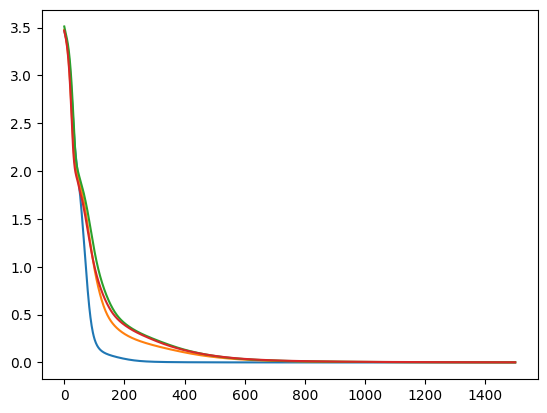

In [27]:
# Train the models 
model1, test1 = train_model(X1,    Y1,    len(ALL_FORMULAS), loss_fn=nn.CrossEntropyLoss())
model2, test2 = train_model(X12,   Y12,   len(ALL_FORMULAS), loss_fn=nn.CrossEntropyLoss())
model3, test3 = train_model(X123,  Y123,  len(ALL_FORMULAS), loss_fn=nn.CrossEntropyLoss())
model4, test4 = train_model(X1234, Y1234, len(ALL_FORMULAS), loss_fn=nn.CrossEntropyLoss())

modelDS4, testDS4 = train_model(X1234, Y1234, len(ALL_FORMULAS), 
                                loss_fn=nn.CrossEntropyLoss(), use_deepsets=True)

In [30]:
# ##########################
# ## Train NN on new data ##
# ##########################

# ## Define X, Y, train/test split 
# X = np.concatenate([X_states_1h, X_props_1h], axis=1)
# Y = Y_labels_num
# Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.2, random_state=0)

# ## Define model 
# model = nn.Sequential(
#                 nn.Linear(X.shape[1], 128), 
#                 nn.ReLU(), 
#                 nn.Linear(128, 64), 
#                 nn.ReLU(), 
#                 nn.Linear(64, len(ALL_FORMULAS)),
# )

# ## Train
# Xt = torch.tensor(Xtr, dtype=torch.float32)
# yt = torch.tensor(Ytr, dtype=torch.long)

# opt = torch.optim.Adam(model.parameters(), lr=1e-3)
# loss_fn = nn.CrossEntropyLoss()

# losses = []
# for epoch in range(1500):
#     opt.zero_grad()
#     loss = loss_fn(model(Xt), yt)
#     loss.backward()
#     opt.step()
#     if epoch%200==0: print(epoch, loss.item())
#     losses.append(loss.item())

# plt.plot(losses);

In [32]:
Xte1, Yte1 = test1
Xte2, Yte2 = test2
Xte3, Yte3 = test3
Xte4, Yte4 = test4

In [33]:
# n_formulas = len(ALL_FORMULAS)

# x = Xte[2]

# state_bits = x[:n_formulas]
# goal_bits  = x[n_formulas:]

# state_formulas = [ALL_FORMULAS[i] for i, b in enumerate(state_bits) if b == 1]
# goal_formula   = ALL_FORMULAS[np.argmax(goal_bits)]

# print("state:", state_formulas)
# print("goal:", goal_formula)
# print("label:", Yte[2])


In [34]:
def test_example(num, Xte):
    state_bits = Xte[num][:len(ALL_FORMULAS)]
    goal_bits  = Xte[num][len(ALL_FORMULAS):]
    state_formulas = [ALL_FORMULAS[i] for i, b in enumerate(state_bits) if b == 1]
    goal_formula   = ALL_FORMULAS[np.argmax(goal_bits)]
#     print("state:", state_formulas)
#     print("goal:", goal_formula)
#     print("label:", Yte[2])
    return {'state': state_formulas, 'goal': goal_formula}

In [41]:
test_example(4, Xte3)

{'state': ['A->B', 'A->D', 'A&B', 'B|D'], 'goal': 'A|B'}

## (6) Improved Theorem Prover

In [49]:
# Not even sure if this is in train or test set .... 
state_check = encode_state(['A', 'A->B', 'B->C'], ALL_FORMULAS)
goal_check =  encode_state(['C'], ALL_FORMULAS)
x_check = np.concatenate([state_check, goal_check])
tt = torch.tensor([x_check], dtype=torch.float32)
logits = model4(tt)
print(logits)
print(torch.argmax(logits).item())
print(f'Model guess is {ALL_FORMULAS[torch.argmax(logits).item()]}')

tensor([[ -7.0675,  14.4118,   8.5472,   3.4995, -11.9302,  -9.7111,  -9.7777,
         -12.6098,  -9.1254, -11.5244, -12.0831,  -9.9677, -12.1290,  -8.7571,
         -10.0783,  -9.9281, -11.2323, -12.9611,  -9.2467, -11.3419,   0.0750,
          -4.6055,   3.2112,   0.7201,  -2.9849,  -0.8739,   0.3351,  -2.2660,
           4.1237,  -0.2631,  -9.8874,  -7.8055]], grad_fn=<AddmmBackward0>)
1
Model guess is B


In [54]:
state_check = encode_state(['A->B', 'A->C', 'D->C', 'B&D'], ALL_FORMULAS)
goal_check =  encode_state(['B|C'], ALL_FORMULAS)
x_check = np.concatenate([state_check, goal_check])
tt = torch.tensor([x_check], dtype=torch.float32)
logits = model2(tt)
print(logits)
print(torch.argmax(logits).item())
print(f'Model guess is {ALL_FORMULAS[torch.argmax(logits).item()]}')

tensor([[ -4.4766,  26.2467,  13.7021,   3.1127, -17.1910, -13.4121, -14.6060,
         -11.7149, -15.7638, -17.9883, -17.1626, -12.6076, -14.0550, -12.3711,
         -13.0563, -13.4335, -16.6703, -18.0853, -11.0837, -16.2686,   0.7432,
           6.6975,  -3.3160, -11.7370,   1.1726,  -5.8158,  -7.6301,  13.9634,
          -8.7370, -21.1590,  -3.7306,  -5.6012]], grad_fn=<AddmmBackward0>)
1
Model guess is B


In [55]:
def TheoremProver2(state, objective, model, ALL_FORMULAS): 
    counter = 0
    nF = len(ALL_FORMULAS)
    while objective not in state: 
        counter += 1
        # Encode
        x = np.concatenate([encode_state(state, ALL_FORMULAS), encode_state([objective], ALL_FORMULAS)])
        tt = torch.tensor([x], dtype=torch.float32)
        logits = model(tt)[0]
        ranked = torch.argsort(logits, descending=True)

        # Try top-k predictions (k = 5 is fine)
        chosen = None
        for idx in ranked[:10]:
            guess = ALL_FORMULAS[idx.item()]
            if guess not in state:
                chosen = guess
                break

        # If none available → stuck
        if chosen is None:
            print("Stuck: all top-k guesses were already in state.")
            break

        # Use the chosen formula
        state.append(chosen)
        print("New state:", state)

        if counter > 10:
            print("Giving up after 10 steps.")
            break

    print("Proved!")

In [58]:
# 2 step exapmles 
TheoremProver2(['A', 'A->B', 'B->C'], 'C', model4, ALL_FORMULAS)
TheoremProver2(['A|B', '~A', 'B->C'], 'C', model4, ALL_FORMULAS)
TheoremProver2(['C', 'C->B', 'A'], 'A&B', model4, ALL_FORMULAS)
TheoremProver2(['A->B', 'A->C', 'D->C', 'B&D'], 'B|C', model4, ALL_FORMULAS)
# 3 step examples 
TheoremProver2(['A', 'A->B', 'B->C', 'C->D'], 'D', model4, ALL_FORMULAS)
TheoremProver2(['A|B', '~B', 'A->C', 'C->D'], 'D', model4, ALL_FORMULAS)
# 4 step examples
# TheoremProver2(['A', 'B', '(A&B)->C', 'C->D'], 'D', model, ALL_FORMULAS)

New state: ['A', 'A->B', 'B->C', 'B']
New state: ['A', 'A->B', 'B->C', 'B', 'C']
Proved!
New state: ['A|B', '~A', 'B->C', 'B']
New state: ['A|B', '~A', 'B->C', 'B', 'C']
Proved!
New state: ['C', 'C->B', 'A', 'B']
New state: ['C', 'C->B', 'A', 'B', 'A&B']
Proved!
New state: ['A->B', 'A->C', 'D->C', 'B&D', 'B']
New state: ['A->B', 'A->C', 'D->C', 'B&D', 'B', 'B|C']
Proved!
New state: ['A', 'A->B', 'B->C', 'C->D', 'D']
Proved!
New state: ['A|B', '~B', 'A->C', 'C->D', 'A']
New state: ['A|B', '~B', 'A->C', 'C->D', 'A', 'C']
New state: ['A|B', '~B', 'A->C', 'C->D', 'A', 'C', 'D']
Proved!


## (7) Faster than Z3 ?  

In [59]:
def TimeToProve(state, goal, model):
    ns_times = []
    bfs_times = []
    for _ in range(100):
        # Neuro-Symbolic
        t0ns = time.time()
        TheoremProver2(state.copy(), goal, model, ALL_FORMULAS)
        t1ns = time.time()
        ns_times.append((t1ns - t0ns) * 1000)

        
        # BFS
        t0bfs = time.time()
        find_shortest_proof(state.copy(), goal, ALL_FORMULAS)
        t1bfs = time.time()
        bfs_times.append((t1bfs - t0bfs) * 1000)

    return [np.mean(ns_times) , np.mean(bfs_times)]

In [83]:
# find some examples that the NN proves correctly, for the time plot
Xtest = Xte4
for n in range(52,55):
    print(f'n is {n}')
    print(len(find_shortest_proof(test_example(n, Xtest)['state'], test_example(n, Xtest)['goal'], ALL_FORMULAS, 4)))
print(test_example(54, Xtest)['state'])
print(test_example(54, Xtest)['goal'])

n is 52
1
n is 53
2
n is 54
3
['A&C', 'C&D', 'A|B', 'B|C']
A&D


In [85]:
# Examples of 1, 2, 3, 4 ! (then plot times below)
TheoremProver2(['B', 'C&D', 'B|C', 'A|D'], 'B|D', model4, ALL_FORMULAS)
TheoremProver2(['C', '~D', 'D->A', 'A&B'], 'A&C', model4, ALL_FORMULAS)
TheoremProver2(['A&C', 'C&D', 'A|B', 'B|C'], 'A&D', model4, ALL_FORMULAS)
TheoremProver2(['A->D', 'B->D', 'B&C'], 'C&D', model4, ALL_FORMULAS)
# TheoremProver2(['A', 'A->B', 'B->C', 'C->D'], 'D', model, ALL_FORMULAS) ## not sure if its in test set

New state: ['B', 'C&D', 'B|C', 'A|D', 'B|D']
Proved!
New state: ['C', '~D', 'D->A', 'A&B', 'A']
New state: ['C', '~D', 'D->A', 'A&B', 'A', 'A&C']
Proved!
New state: ['A&C', 'C&D', 'A|B', 'B|C', 'A']
New state: ['A&C', 'C&D', 'A|B', 'B|C', 'A', 'D']
New state: ['A&C', 'C&D', 'A|B', 'B|C', 'A', 'D', 'A&D']
Proved!
New state: ['A->D', 'B->D', 'B&C', 'B']
New state: ['A->D', 'B->D', 'B&C', 'B', 'C']
New state: ['A->D', 'B->D', 'B&C', 'B', 'C', 'D']
New state: ['A->D', 'B->D', 'B&C', 'B', 'C', 'D', 'C&D']
Proved!


In [86]:
import contextlib, os
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    times0 = TimeToProve(['B', 'C&D', 'B|C', 'A|D'], 'B|D', model4)
    times1 = TimeToProve(['B', 'D', 'B->D', 'C&D'], 'A|C', model4)
    times2 = TimeToProve(['~A', 'C&D', 'A|B', 'B|D'], 'B&D', model4)
    times3 = TimeToProve(['B', 'A->C', 'A&D'], 'C&D', model4)

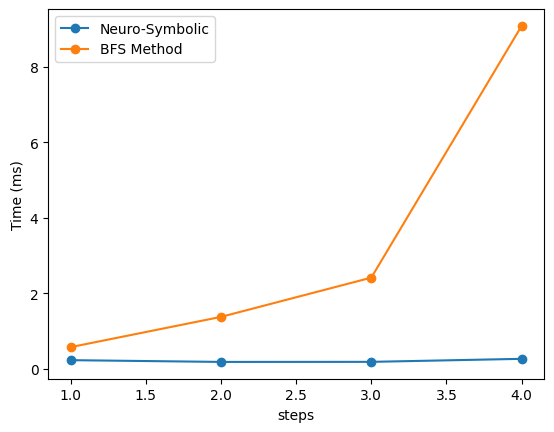

In [87]:
plt.plot([1, 2, 3, 4], [times0[0], times1[0], times2[0], times3[0]], marker='o')
plt.plot([1, 2, 3, 4], [times0[1], times1[1], times2[1], times3[1]], marker='o');
##~~~~ NN failed for steps = 4 ~~~~~~~~
# plt.scatter(4, times3[0], marker='x', color='red', s=100)
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.ylabel('Time (ms)')
plt.xlabel('steps')
plt.legend(['Neuro-Symbolic', 'BFS Method'])

## (8) Overall Accuracy

In [131]:
def prove_with_nn(state, goal, model, ALL_FORMULAS, max_steps=5):
    '''
    Given state, goal ... try to prove goal with NN.  
    Returns True if successful 
    Returns False if not
    '''
    state = list(state)
    
    # True shortest depth
    true_path = find_shortest_proof(state, goal, ALL_FORMULAS, 5)
    if true_path is None: return False
    true_depth = len(true_path)
    
    steps_taken = 0

    for _ in range(max_steps):
        if goal in state:
            return steps_taken==true_depth  

        # encode, rank predictions
        x = np.concatenate([encode_state(state, ALL_FORMULAS),encode_state([goal], ALL_FORMULAS)])
        tt = torch.tensor([x], dtype=torch.float32)
        logits = model(tt)[0]
        ranked = torch.argmax(logits).item()  # most likely next step

        f = ALL_FORMULAS[ranked]

        if f in state or not verify_step_small(state, f): 
            return False

        state.append(f)
        steps_taken+=1

    return False  # max steps reached


In [132]:
def final_check_NN(Xtest, model):
    def get_test_case(i):
        state = test_example(i, Xtest)['state']
        goal = test_example(i, Xtest)['goal']
        return state, goal

    correct = 0
    total = len(Xtest)

    for i in range(total):
        state, goal = get_test_case(i)
        if prove_with_nn(state, goal, model, ALL_FORMULAS): # if NN can prove goal ... 
            correct += 1

    print("Global Proof Accuracy:", correct, "/", total, "=", correct/total)

final_check_NN(Xte1, model1)
final_check_NN(Xte2, model2)
final_check_NN(Xte3, model3)
final_check_NN(Xte4, model4)

Global Proof Accuracy: 2795 / 2795 = 1.0
Global Proof Accuracy: 5786 / 5826 = 0.9931342258839684
Global Proof Accuracy: 6341 / 6467 = 0.9805164682232874
Global Proof Accuracy: 6492 / 6668 = 0.9736052789442111


In [133]:
def accuracy_by_depth(Xte, model, ALL_FORMULAS):
    results = {}
    true_depths = []

    for i in range(len(Xte)):
        state, goal = test_example(i, Xte)['state'], test_example(i, Xte)['goal']
        path  = find_shortest_proof(state, goal, ALL_FORMULAS, 5)
        true_depths.append(len(path))
    depths = sorted(set(true_depths))

    for d in depths:
        idxs = [i for i,depth in enumerate(true_depths) if depth == d]
        if len(idxs) == 0:
            continue
            
    
        correct = 0
        for i in idxs:
            state, goal = test_example(i, Xte)['state'], test_example(i, Xte)['goal']
            if prove_with_nn(state, goal, model, ALL_FORMULAS):
                correct += 1

        results[d] = correct / len(idxs)

    return results

In [135]:
acc1 = accuracy_by_depth(Xte4, model1, ALL_FORMULAS)
acc2 = accuracy_by_depth(Xte4, model2, ALL_FORMULAS)
acc3 = accuracy_by_depth(Xte4, model3, ALL_FORMULAS)
acc4 = accuracy_by_depth(Xte4, model4, ALL_FORMULAS)
print(acc1)
print(acc2)
print(acc3)
print(acc4)

{1: 1.0, 2: 0.0, 3: 0.0, 4: 0.0}
{1: 0.9992844364937388, 2: 0.9894459102902374, 3: 0.6708661417322834, 4: 0.04854368932038835}
{1: 0.9992844364937388, 2: 0.9910949868073878, 3: 0.8393700787401575, 4: 0.5242718446601942}
{1: 1.0, 2: 0.9907651715039578, 3: 0.878740157480315, 4: 0.6553398058252428}


[[1.         0.         0.         0.        ]
 [0.99928444 0.98944591 0.67086614 0.04854369]
 [0.99928444 0.99109499 0.83937008 0.52427184]
 [1.         0.99076517 0.87874016 0.65533981]]


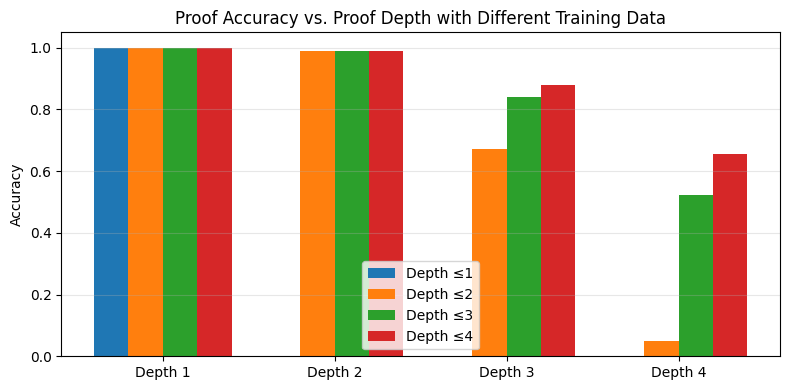

In [138]:
accs = [acc1, acc2, acc3, acc4]
labels = ["Depth ≤1", "Depth ≤2", "Depth ≤3", "Depth ≤4"]

# Collect union of depths that appear
all_depths = sorted(set().union(*[acc.keys() for acc in accs]))

# Build matrix of accuracies (missing depth → NaN)
data = np.array([
    [acc.get(d, np.nan) for d in all_depths]
    for acc in accs
])

print(data)

# --- Plot ---
x = np.arange(len(all_depths))            # depth positions
width = 0.2                               # bar width

plt.figure(figsize=(8,4))
for i in range(len(accs)):
    plt.bar(x + i*width, data[i], width, label=labels[i])

plt.xticks(x + width*1.5, [f"Depth {d}" for d in all_depths])
plt.ylabel("Accuracy")
plt.ylim(0,1.05)
plt.legend(loc='lower center')
plt.title("Proof Accuracy vs. Proof Depth with Different Training Data")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
